In [1]:
%matplotlib inline
from astropy.stats import sigma_clipped_stats
from photutils import CircularAperture, aperture_photometry, CircularAnnulus, DAOStarFinder
import astropy.io.fits as pf
import numpy as np
import seaborn as sns
sns.set()
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.wcs import WCS
from matplotlib import pyplot as plt
import os
from scipy import stats
from scipy.optimize import curve_fit
from scipy import odr

In [2]:
os.chdir(r'C:\Users\garyc\Desktop\4th Year\Astro Project')
file = 'wcsT_0036.fits'
image = pf.open(file)
w = WCS(image[0].header)
sky = w.pixel_to_world(100,100)
print(sky)

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (101.95773611, 4.12757861)>


In [3]:
x = [101.839311,101.834507,101.755641,101.829614,101.810250,101.822584,101.744490,101.765208,101.735356,101.753151]
y = [03.929904,3.911874,3.933425,03.943406,3.939188,03.941496,04.009061,04.004846,3.993880,3.963151]
a = []
b = []
for i,j in zip(x,y):
    px, py = w.wcs_world2pix(i,j, 1)
    a.append(px)
    b.append(py)
    #print('{0} {1}'.format(px, py))
    
os.chdir(r'C:\Users\garyc\Desktop\4th Year\Astro Project\1V Reduced\1500 1500 files')
file = 'reduceducdT_0036.fits'
image = pf.getdata(file)


a = np.array(a)
b = np.array(b)
a = a-1250
b = b-1250
print(a)
print(b)
mean, median, std = sigma_clipped_stats(image, sigma=3)
daofind = DAOStarFinder(fwhm=5.0, threshold=3*std) 
sources = daofind(image - median)
for col in sources.colnames: 
    sources[col].info.format = '%.8g'

positions = []
for i,j in zip(a,b):
    ID = []
    xref = i
    yref = j
    for k,l,m in zip(sources['xcentroid'],sources['ycentroid'],sources['id']):
        if -10<(k-xref)<10 and -10<(l-yref)<10:
            n = m-1
            ID.append(n)
            positions.append((k,l))
    print(sources[ID])

[ 184.65516138  237.81140243 1143.68529581  297.17264498  518.5962095
  377.519538   1279.27165942 1041.47665242 1382.34807119 1175.29257282]
[1135.80422351 1343.24754915 1104.82686889  981.96228466 1032.55283495
 1004.67495372  238.13037212  284.17654169  413.35915353  763.99167838]
 id  xcentroid ycentroid sharpness ... sky    peak      flux      mag    
---- --------- --------- --------- ... --- --------- --------- ----------
1282 183.33934 1135.3379 0.4213063 ...   0 185.37884 24.302863 -3.4641436
 id  xcentroid ycentroid sharpness ... sky   peak      flux      mag    
---- --------- --------- --------- ... --- -------- --------- ----------
1507 236.79658 1341.8911 0.4400257 ...   0 146.5862 20.567143 -3.2829349
 id  xcentroid ycentroid sharpness  ... sky    peak      flux      mag   
---- --------- --------- ---------- ... --- --------- --------- ---------
1255 1134.3405 1104.4913 0.43110086 ...   0 140.22068 18.505857 -3.168273
 id  xcentroid ycentroid sharpness  ... sky    peak 

In [4]:
positions = [(183.33934,1135.3379),(236.79658,1341.8911),(1134.3405,1104.4913),(296.06838,979.71668),
             (518.16387,1031.4501),(375.8214,1005.7163),(1279.6085,237.09353),(1039.794,283.22661),
             (1381.9855,411.13524),(1174.2243,762.58534)]

In [5]:
mags = []
magserrors = []
for i in positions:
    aperture = CircularAperture(i, r=6) 
    annulus_aperture = CircularAnnulus(i, r_in=12., r_out=15.)
    apers = [aperture, annulus_aperture]
    phot_table = aperture_photometry(image, apers)
    for col in phot_table.colnames:
        phot_table[col].info.format = '%.8g'
    bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
    bkg_total = bkg_mean * aperture.area
    net_star = phot_table['aperture_sum_0'] - bkg_total
    mags.append(-2.5*np.log10(phot_table['aperture_sum_0'][0]))
    dfdx = -1.08574/phot_table['aperture_sum_0'][0]
    error = np.sqrt((dfdx**2)*(np.sqrt(phot_table['aperture_sum_0'][0]))**2)
    magserrors.append(error)

[  0.78489669 -21.61787917]
[[ 0.00036835 -0.0053048 ]
 [-0.0053048   0.07662638]]
Beta: [  0.77873965 -21.51353862]
Beta Std Error: [0.02120562 0.31572914]
Beta Covariance: [[ 0.00019073 -0.002838  ]
 [-0.002838    0.04228215]]
Residual Variance: 2.3576115641022932
Inverse Condition #: 0.01432865641925577
Reason(s) for Halting:
  Sum of squares convergence


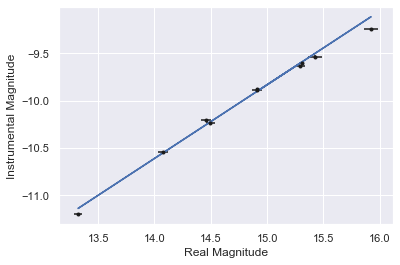

In [6]:
mags = np.array(mags)
realmag = [14.909,15.313,15.289,14.459,13.321,14.072,14.495,15.924,15.427,14.909]
realmag = np.array(realmag)
realmagerrors = [0.0032,0.0074,0.044,0.042,0.037,0.044,0.039,0.063,0.062,0.043]
plt.errorbar(realmag,mags,magserrors,realmagerrors,fmt='.',color='k')
plt.ylabel('Instrumental Magnitude')
plt.xlabel('Real Magnitude')

def f(x,m,c):
    return m*x+c
popt, pcov = curve_fit(f,realmag,mags,sigma=magserrors)
print(popt)

def func(p, x):
    m, c = p
    return m*x + c
mydata = odr.RealData(realmag, mags, sx = realmagerrors, sy = magserrors)
linear = odr.Model(func)
myodr = odr.ODR(mydata, linear,beta0 =[1, -23])
myoutput = myodr.run()
y = myoutput.beta[0]*realmag+myoutput.beta[1]
plt.plot(realmag,y)
print(pcov)
myoutput.pprint()

In [7]:
xref = 764
yref = 712

mean, median, std = sigma_clipped_stats(image, sigma=6)
daofind = DAOStarFinder(fwhm=5.0, threshold=3*std) 
sources = daofind(image - median)
for col in sources.colnames: 
    sources[col].info.format = '%.8g'
for k,l,m in zip(sources['xcentroid'],sources['ycentroid'],sources['id']):
    if -10<(k-xref)<10 and -10<(l-yref)<10:
        n = m-1
        ID.append(n)
print(sources[ID])

 id xcentroid ycentroid sharpness  ... sky    peak      flux       mag     
--- --------- --------- ---------- ... --- --------- --------- ------------
868 1429.1863 1128.0744 0.69499109 ...   0 5.0160065 1.0804757 -0.084037552
547 761.98074 713.00024 0.45386521 ...   0 13597.697 1775.8625   -8.1235233


In [8]:
sourcemag = []
sourcemagerror = []
position = [(761.98074,713.00024)]
aperture = CircularAperture(position[0], r=2) 
annulus_aperture = CircularAnnulus(position[0], r_in=12., r_out=15.)
apers = [aperture, annulus_aperture]
phot_table = aperture_photometry(image, apers)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
bkg_total = bkg_mean * aperture.area
net_star = phot_table['aperture_sum_0'] - bkg_total
sourcemag.append(-2.5*np.log10(phot_table['aperture_sum_0'][0]))
sourcemagerror.append((-1.08574/phot_table['aperture_sum_0'][0])*np.sqrt(phot_table['aperture_sum_0'][0]))
print(sourcemag)

[-12.8385401184917]


In [9]:
dy = 1/myoutput.beta[0]
dc = -1/myoutput.beta[0]
dm = (myoutput.beta[1]-sourcemag[0])/(myoutput.beta[0])**2
error = np.sqrt((dy**2)*sourcemagerror[0]**2+(dc**2)*(myoutput.sd_beta[1])**2+(dm**2)*(myoutput.sd_beta[0])**2)
print((sourcemag[0]-myoutput.beta[1])/myoutput.beta[0],'+/-',error)

11.139793068633976 +/- 0.506369786780245
